# Biophysical and reduced neuronal models

## Generic code architecture for model construction

In [191]:
#Modl params

#Run controls

#DAQ vector instantiation

#Initialization

#Helper fxns (eqns)

#Integrator

#Package DAQ vector(s) into intuitive data structure

#I.O

## Hodgkin-Huxley Neuron Model

### Charge conservation equation

$$C_{m}\frac{dV_{m}}{dt} = -\sum_{i \in \{I_{Na}, I_{K}, I_{pas}\}} I_{i} + I_{0}$$

### Current equations (where i $\in$ {Na, K, pas} and j, k, z $\geq$ 0)

$$I_{i} = \bar{g}_{i}m^{j}h^{k}n^{z}(V - E_{i})$$

### Gating dynamic equations (where p $\in$ {m, h, b})

$$\frac{dp}{dt} = \alpha_{p}(V_m)(1 - p) - \beta_{p}(V_{m})p$$

### Rate constant equations

#### m

$$\alpha_{m} = \frac{0.01(25 - V_{m})}{e^{\frac{25 - V_{m}}{10}} - 1}$$

$$\beta_{m} = 4e^{-\frac{V_{m}}{18}}$$

#### h

$$\alpha_{h} = 0.07e^{-\frac{V_{m}}{20}}$$

$$\beta_{h} = \frac{1}{e^{\frac{30 - V_{m}}{10}} - 1}$$

#### n

$$\alpha_{n} = \frac{0.01(10 - V_{m})}{e^{\frac{10 - V_{m}}{10}} - 1}$$

$$\beta_{n} = 0.125e^{-\frac{V_{m}}{80}}$$

#### $\infty$ (steady-state) equations (where p $\in$ {m, h, n})

$$p_{\infty} = \frac{\alpha_{p}}{\alpha_{p} + \beta_{p}} $$


In [276]:
###Sys block
from warnings import simplefilter
simplefilter(action = 'ignore')
from random import seed
seed(120622)

###Lib block
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sbn
from random import gauss, uniform
from sklearn.metrics import mean_squared_error as mse
from IPython.display import HTML

In [193]:
###Main block
#Modl params
gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
e_na, e_k, e_pas = 115, -12, 10.6
i_0, c_m = 10, 1

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ vector instantiation
v, m, h, n = [], [], [], []

#Helper fxns (eqns)
def alpha_m(v):
    return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))

def beta_m(v):
    return(4 * np.exp(-v / 18))

def alpha_h(v):
    return(0.07 * np.exp(-v / 20))

def beta_h(v):
    return(1 / (np.exp ((30 - v) / 10) + 1))

def alpha_n(v):
    return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))

def beta_n(v):
    return(0.125 * np.exp(-v / 80))

def dmdt(v, m):
    return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))

def dhdt(v, h):
    return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))

def dndt(v, n):
    return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))

def i_na(gbar_na, m, h, v, e_na):
    return((gbar_na * (m ** 3) * h * (v - e_na)))

def i_k(gbar_k, n, v, e_k):
    return((gbar_k * (n ** 4)) * (v - e_k))

def i_pas(gbar_pas, v, e_pas):
    return(gbar_pas * (v - e_pas))
    
def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, i_0, c_m):
    return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + i_0) / c_m)

###Initialization
##Initialize voltage
v.append(0)

##Initialize state vars
#Fxns iterable
fxns = [[alpha_m, beta_m],
        [alpha_h, beta_h],
        [alpha_n, beta_n]]

#State-vars iterable
sVars = [m, h, n]

#Iteratively initialize state vars
for i,_ in enumerate(fxns):
    sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                              gbar_na, gbar_k, gbar_pas, 
                              e_na, e_k, e_pas,
                              i_0, c_m))
    m.append(m[i] + dt * dmdt(v[i], m[i]))
    h.append(h[i] + dt * dhdt(v[i], h[i]))
    n.append(n[i] + dt * dndt(v[i], n[i]))

#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': v}) \
         .query('t >= 960 & t <= 995') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,960.000,-3.220631
1,960.025,-3.167730
2,960.050,-3.114805
3,960.075,-3.061856
4,960.100,-3.008888


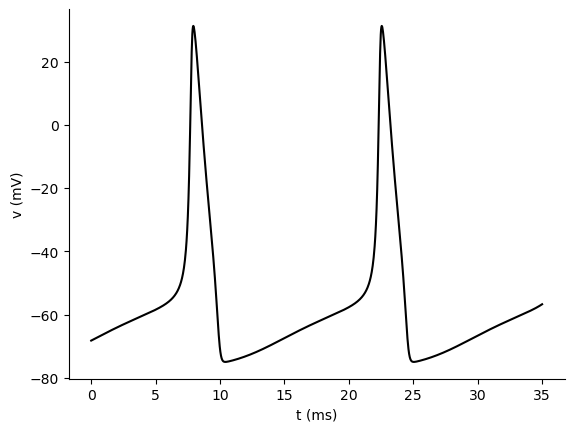

In [194]:
#Visualization
plt.figure()
plt.plot(data['t'] - min(data['t']), 
         data['v'] - 65,
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Hodgkin-Huxley Model Compared to Biological Spiker

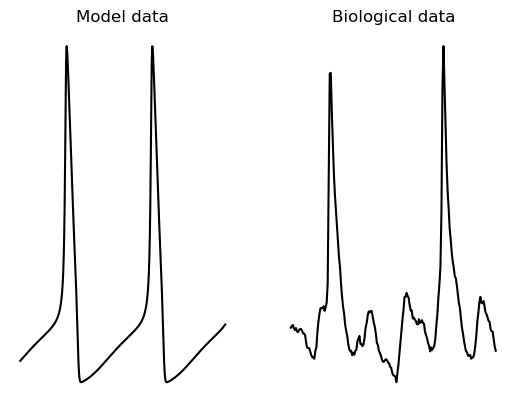

In [195]:
#Data dump
biolData = pd.read_csv('./data/biologicalSpiker.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hodgkin-Huxley Model With Noise Compared to Biological Spiker

### Charge conservation equation with additive noise

$$C_{m}\frac{dV_{m}}{dt} = -\sum_{i \in \{I_{Na}, I_{K}, I_{pas}\}} I_{i} + w\xi + I_{0}$$


In [196]:
###Main block
#Modl params
gbar_na, gbar_k, gbar_pas = 120, 36, 0.3
e_na, e_k, e_pas = 115, -12, 10.6
w, i_0, c_m = 25, 10, 1

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ vector instantiation
v, m, h, n = [], [], [], []

#Helper fxns (eqns)
def alpha_m(v):
    return((0.1 * (25 - v)) / (np.exp((25 - v) / 10) - 1))

def beta_m(v):
    return(4 * np.exp(-v / 18))

def alpha_h(v):
    return(0.07 * np.exp(-v / 20))

def beta_h(v):
    return(1 / (np.exp ((30 - v) / 10) + 1))

def alpha_n(v):
    return((0.01 * (10 - v)) / (np.exp((10 - v)/ 10) - 1))

def beta_n(v):
    return(0.125 * np.exp(-v / 80))

def dmdt(v, m):
    return((alpha_m(v) * (1 - m)) - (beta_m(v) * m))

def dhdt(v, h):
    return((alpha_h(v) * (1 - h)) - (beta_h(v) * h))

def dndt(v, n):
    return((alpha_n(v) * (1 - n)) - (beta_n(v) * n))

def i_na(gbar_na, m, h, v, e_na):
    return((gbar_na * (m ** 3) * h * (v - e_na)))

def i_k(gbar_k, n, v, e_k):
    return((gbar_k * (n ** 4)) * (v - e_k))

def i_pas(gbar_pas, v, e_pas):
    return(gbar_pas * (v - e_pas))
    
def dvdt(v, m, h, n, gbar_na, gbar_k, gbar_pas, e_na, e_k, e_pas, w, i_0, c_m):
    return((- i_na(gbar_na, m, h, v, e_na) - i_k(gbar_k, n, v, e_k) - i_pas(gbar_pas, v, e_pas) + (w * gauss(mu = 0, sigma = 1)) + i_0) / c_m)

###Initialization
##Initialize voltage
v.append(0)

##Initialize state vars
#Fxns iterable
fxns = [[alpha_m, beta_m],
        [alpha_h, beta_h],
        [alpha_n, beta_n]]

#State-vars iterable
sVars = [m, h, n]

#Iteratively initialize state vars
for i,_ in enumerate(fxns):
    sVars[i].append(fxns[i][0](v[0]) / (fxns[i][0](v[0]) + fxns[i][1](v[0])))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    v.append(v[i] + dt * dvdt(v[i], m[i], h[i], n[i], 
                              gbar_na, gbar_k, gbar_pas, 
                              e_na, e_k, e_pas,
                              w, i_0, c_m))
    m.append(m[i] + dt * dmdt(v[i], m[i]))
    h.append(h[i] + dt * dhdt(v[i], h[i]))
    n.append(n[i] + dt * dndt(v[i], n[i]))

#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': v}) \
         .query('t >= 960 & t <= 995') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,960.000,-8.686479
1,960.025,-7.601745
2,960.050,-7.555722
3,960.075,-7.411587
4,960.100,-8.228261


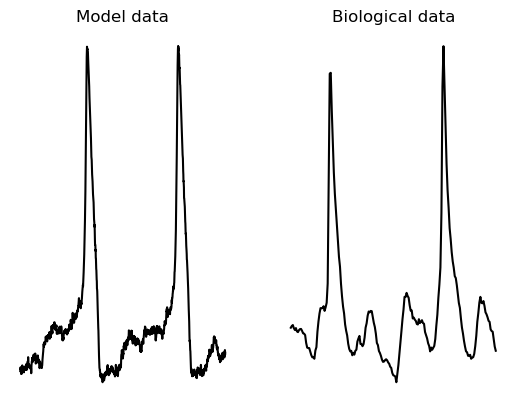

In [197]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hindmarsh-Rose Neuron Model

### System of differential equations

$$\frac{dx}{dt} = y - ax^{3} + bx^{2} - z + i$$

$$\frac{dy}{dt} = c - dx^{2} - y$$

$$\frac{dz}{dt} = r(s(x - x_{1}) - z)$$

In [198]:
###Main block
#Modl params
a, b, c, d = 1, 3, 1, 5
r, s, x0, i_ = 0.001, 4, -1.6, 2

#Run controls
time, dt = 2000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 3))

#Initialization
sVars[0] = np.array([0.5, 0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    x, y, z = sVars

    #Compute RHS of ODEs
    dxdt = y - a * (x ** 3) + b * (x ** 2) - z + i_
    dydt = c - d * (x ** 2) - y
    dzdt = r * (s * (x - x0) - z)

    #Fxn I.O
    return(np.array([dxdt, dydt, dzdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'x': sVars[:, 0]}) \
         .query('t >= 1000 & t <= 1750') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,x
0,1000.00,-1.532801
1,1000.01,-1.532784
2,1000.02,-1.532768
3,1000.03,-1.532751
4,1000.04,-1.532735


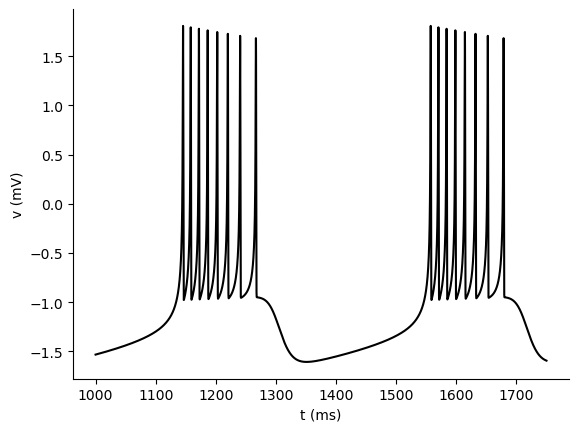

In [199]:
#Visualization
plt.figure()
plt.plot(data['t'], 
         data['x'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Hindmarsh-Rose Model Compared to Biological Burster

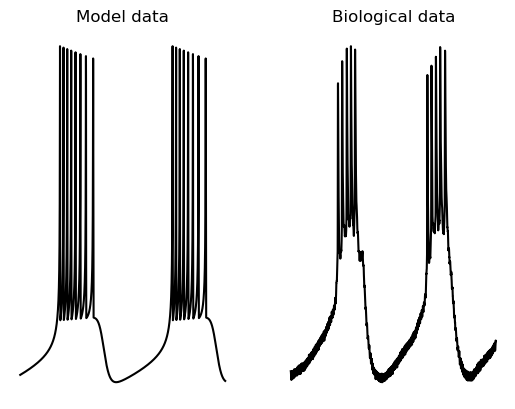

In [200]:
#Data dump
biolData = pd.read_csv('./data/biologicalBurster.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['x'],
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## Hindmarsh-Rose Model With Noise Compared to Biological Burster

### Voltage-representing, state-variable equation with additive noise

$$\frac{dx}{dt} = y - ax^{3} + bx^{2} - z + w\xi + i$$

In [201]:
###Main block
#Modl params
a, b, c, d = 1, 3, 1, 5
r, s, x0, i_ = 0.001, 4, -1.6, 2
w = 1

#Run controls
time, dt = 2000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 3))

#Initialization
sVars[0] = np.array([0.5, 0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    x, y, z = sVars

    #Compute RHS of ODEs
    dxdt = y - a * x ** 3 + b * x ** 2 - z + (w * gauss(mu = 0, sigma = 1)) + i_
    dydt = c - d * x ** 2 - y
    dzdt = r * (s * (x - x0) - z)

    #Fxn I.O
    return(np.array([dxdt, dydt, dzdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'x': sVars[:, 0]}) \
         .query('t >= 1000 & t <= 1750') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,x
0,1000.00,-1.472408
1,1000.01,-1.482756
2,1000.02,-1.483776
3,1000.03,-1.480185
4,1000.04,-1.478846


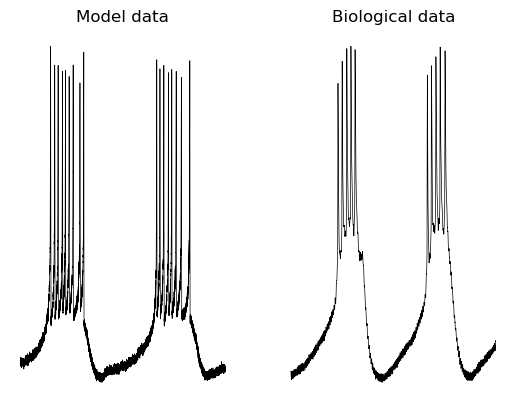

In [202]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['x'],
         linewidth = 0.5,
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         linewidth = 0.5,
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Draw visualization to jupyter
plt.show()

## Izhikevich Neuron Model

### System of differential equations

$$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u + i$$

$$\frac{du}{dt} = a(bv - u)$$

<p style = "text-align: center;">if $v = 30 mV$ then</p> 

$$v \leftarrow c$$
$$u \leftarrow u + d$$

## ...as spiker

In [203]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -65, 8
i_ = 10

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i, T in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,v
0,900.00,-70.935316
1,900.01,-70.932249
2,900.02,-70.929181
3,900.03,-70.926114
4,900.04,-70.923046


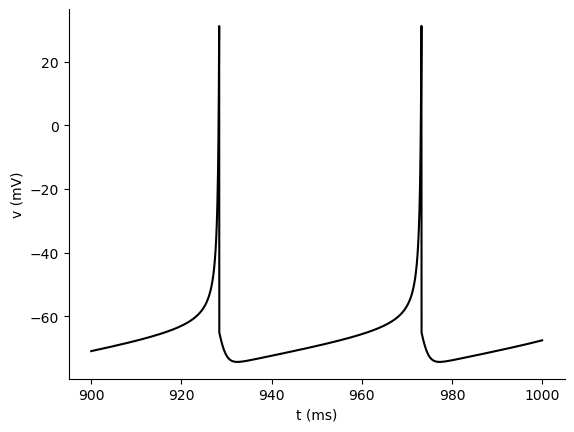

In [204]:
#Visualization
plt.figure()
plt.plot(data['t'], 
         data['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## ...as burster

In [205]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -50, 2
i_ = 15

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i, T in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data_ = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
          .query('t >= 900') \
          .reset_index(drop = True) 

#I.O
data_.head()

,t,v
0,900.00,-69.019385
1,900.01,-69.014446
2,900.02,-69.009506
3,900.03,-69.004563
4,900.04,-68.999619


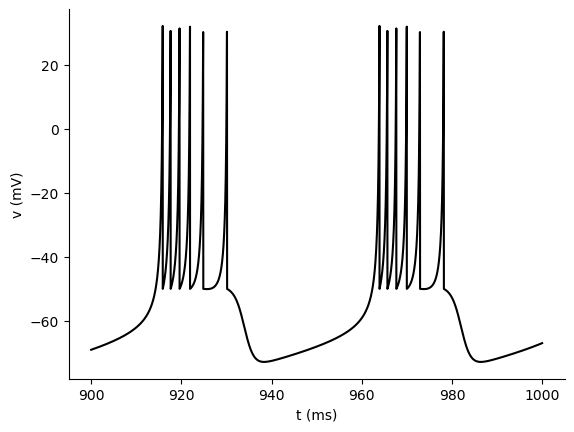

In [206]:
#Visualization
plt.figure()
plt.plot(data_['t'], 
         data_['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## Izhikevich Model Compared to Biological Neurons

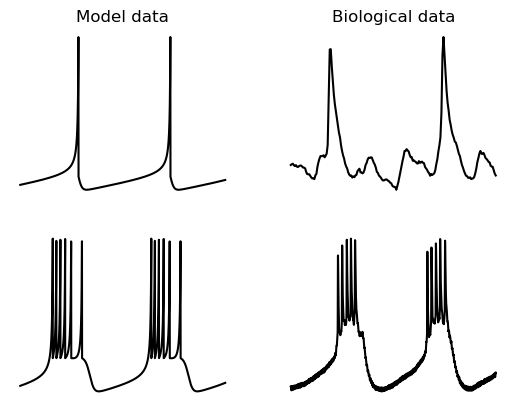

In [207]:
#Data dump
biolData = pd.read_csv('./data/biologicalSpiker.csv')
biolData_ = pd.read_csv('./data/biologicalBurster.csv')

##Visualization
#Creation of graphics device
plt.figure()

#Creation of iterables
sp = [221, 222, 223, 224]
xy = [data, biolData, data_, biolData_]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(xy[i]['t'],
             xy[i]['v'],
             color = 'black')
    plt.axis('off')

    if i == 0:
        plt.title('Model data')

    if i == 1:
        plt.title('Biological data')

#Render visualization to jupyter
plt.show()

## Izhikevich Model With Noise Compared to Biological Neurons

### Voltage-representing, state-variable equation with additive noise

$$\frac{dv}{dt} = 0.04v^{2} + 5v + 140 - u + w\xi + i$$

## ...as spiker

In [208]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -65, 8
w, i_ = 10, 10

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i, T in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True) 

#I.O
data.head()

,t,v
0,900.00,-69.244225
1,900.01,-69.222449
2,900.02,-69.261061
3,900.03,-69.312373
4,900.04,-69.442575


## ...as burster

In [209]:
###Main block
#Modl params
a, b, c, d = 0.02, 0.2, -50, 2
w, i_ = 10, 15

#Run controls
time, dt = 1000, 0.01
n = time / dt
t = np.arange(0 + dt, time, dt)

#Anti-bug run controls
if not len(t) == (n - 1):
    sys.exit(1)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([-70, 15])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, u = sVars

    #Compute RHS of ODEs
    dvdt = 0.04 * v ** 2 + 5 * v + 140 - u + (w * gauss(mu = 0, sigma = 1)) + i_
    dudt = a * (b * v - u)
        
    #Fxn I.O
    return(np.array([dvdt, dudt]))

#Integrate with conditional using forward-Euler formalism
for i, T in enumerate(t):
    if sVars[i, 0] >= 30:
        sVars[i + 1] = np.array([c, (sVars[i, 1] + d)])

    else:
        sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data_ = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
          .query('t >= 900') \
          .reset_index(drop = True) 

#I.O
data_.head()

,t,v
0,900.00,-62.993644
1,900.01,-62.786875
2,900.02,-62.499059
3,900.03,-62.436780
4,900.04,-62.565752


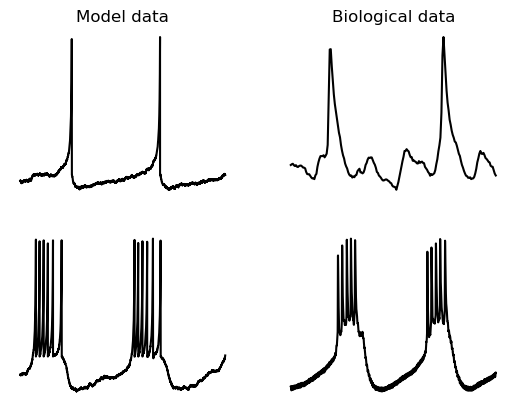

In [210]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of iterables
sp = [221, 222, 223, 224]
xy = [data, biolData, data_, biolData_]

#Construct iteratively each panel
for i,_ in enumerate(sp):
    plt.subplot(sp[i])
    plt.plot(xy[i]['t'],
             xy[i]['v'],
             color = 'black')
    plt.axis('off')

    if i == 0:
        plt.title('Model data')

    if i == 1:
        plt.title('Biological data')

#Render visualization to jupyter
plt.show()

# Parameter search and optimization methodologies

## Toy Linear Regression Model

$$y = mx + b$$

In [211]:
###Main block
#Modl params
m, b = 100, 10

#IV/feature/predictor/EV vector
x = np.arange(1, (10 + 1))

#Helper fxn (eqn)
def fx():
    return(m * x + b)

#Compute modl output
y = fx()
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'x': x,
                     'y': y})

#I.O
data.head()

,x,y
0,1,110
1,2,210
2,3,310
3,4,410
4,5,510


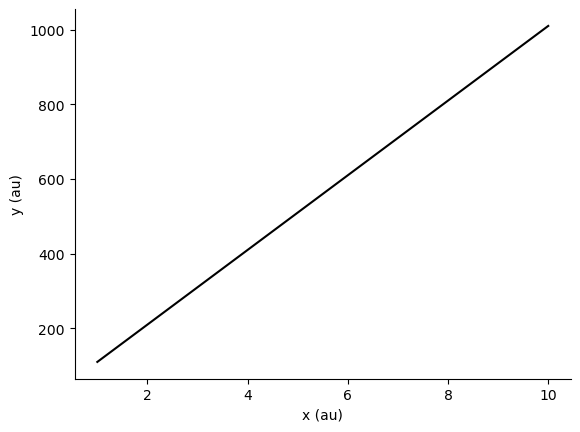

In [212]:
#Visualization
plt.figure()
plt.plot(data['x'], 
         data['y'],
         color = 'black')
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.show()

## Parameter search (hand tuning; brute force; random parameter)

### Functionalize Toy Model

In [213]:
###Fxn block
def toyModl(m, b = 10):
    '''
    
    Fxnalized modl object
    - Model params are now fxn args
    
    '''
    
    #IV/feature/predictor/EV vector
    x = np.arange(1, (10 + 1))
    
    #Helper fxn (eqn)
    def fx():
        return(m * x + b)
    
    #Compute modl output
    y = fx()
        
    #Package vectors in nd heterogenous df
    data = pd.DataFrame({'x': x,
                         'y': y})
    
    #I.O
    return(data)

###Main block
#Compute modl results
toyModl(m = 100).head()

,x,y
0,1,110
1,2,210
2,3,310
3,4,410
4,5,510


### Hand Tune Toy Model

$$m \in [0, 100]$$

m = 10


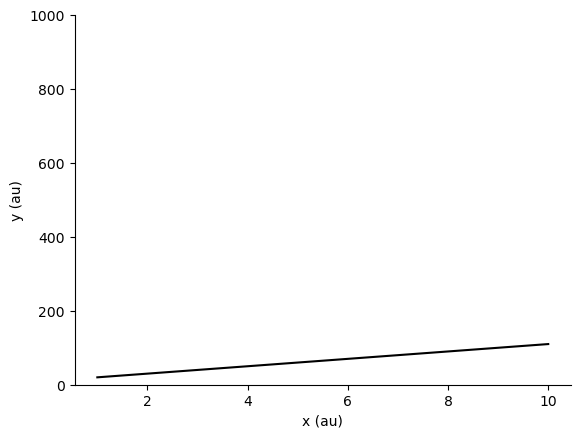

In [215]:
###Main block
#Compute modl results
data = toyModl(m = int(input('m =')))

#Visualization
plt.figure()
plt.plot(data['x'], 
         data['y'],
         color = 'black')
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)
plt.show()

### Subject Toy Model to Brute Force, Sparse Grid Search

In [216]:
###Main block
##Create param iterable
#Sparse 1D grid comprising feature space
m = np.arange(0, 100, 10)

#DAQ list-column instantiation
modls = []

#Compute modl outputs across grid
for i,_ in enumerate(m):
    if i == 0:
        modls.append(toyModl(m = m[i]))

    else:
        modls.append(toyModl(m = m[i])['y'] \
             .rename(f'y{i}'))
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,x,y,y1,y2,y3,y4,y5,y6,y7,y8,y9
0,1,10,20,30,40,50,60,70,80,90,100
1,2,10,30,50,70,90,110,130,150,170,190
2,3,10,40,70,100,130,160,190,220,250,280
3,4,10,50,90,130,170,210,250,290,330,370
4,5,10,60,110,160,210,260,310,360,410,460


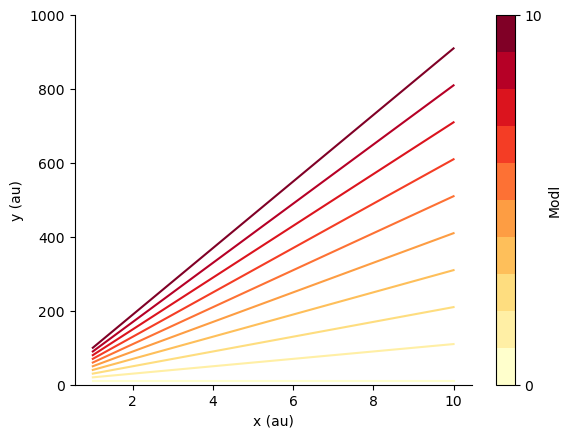

In [217]:
##Visualization
#Creation of graphics device
plt.figure()

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.iloc[:, 1:]))
cols = cmap(range(len(data.iloc[:, 1:])))

#Construct iteratively each panel
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = cols[i])

#Alter graphics device attributes
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)

#Create ScalarMappable
sm = cm.ScalarMappable(cmap = cmap)

#Build legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels(['0', '10'])

#Render visualization to jupyter
plt.show()

### Subject Toy Model to Random Parameter Search

In [230]:
###Main block
##Initialize iterator
i = 0

##Create conditional boundary
n = 10 - 1

#DAQ list-column instantiation
modls = []

#Compute modl outputs subject to Monte-Carlo m selection
while i <= n:
    if i == 0:
        modls.append(toyModl(m = uniform(0, 101)))

    else:
        modls.append(toyModl(m = uniform(0, 101))['y'] \
             .rename(f'y{i}'))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)

#I.O
data.head()

,x,y,y1,y2,y3,y4,y5,y6,y7,y8,y9
0,1,45.534973,49.86934,58.183951,35.621778,41.150535,34.533329,104.630086,25.357224,96.174715,21.052195
1,2,81.069946,89.73868,106.367902,61.243557,72.301069,59.066658,199.260173,40.714447,182.349430,32.104391
2,3,116.604919,129.60802,154.551853,86.865335,103.451604,83.599988,293.890259,56.071671,268.524145,43.156586
3,4,152.139892,169.47736,202.735804,112.487113,134.602138,108.133317,388.520346,71.428894,354.698860,54.208782
4,5,187.674865,209.34670,250.919756,138.108892,165.752673,132.666646,483.150432,86.786118,440.873575,65.260977


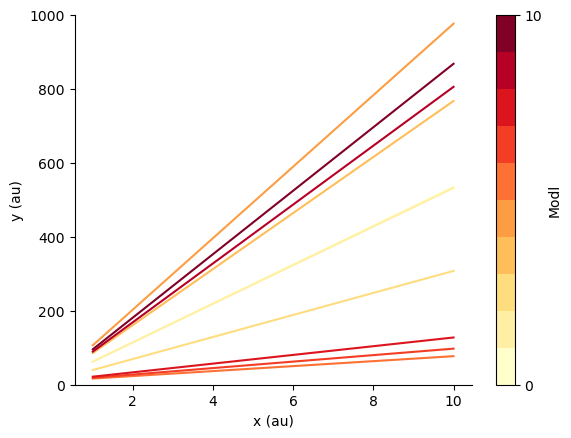

In [219]:
##Visualization
#Creation of graphics device
plt.figure()

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.iloc[:, 1:]))
cols = cmap(range(len(data.iloc[:, 1:])))

#Construct iteratively each panel
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(data['x'],
             data[val],
             color = cols[i])

#Alter graphics device attributes
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)

#Create ScalarMappable
sm = cm.ScalarMappable(cmap = cmap)

#Build legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels(['0', '10'])

#Render visualization to jupyter
plt.show()

## Optimization methodologies (random parameter search; gradient descent)

### Optimization (i.e., Target) Data

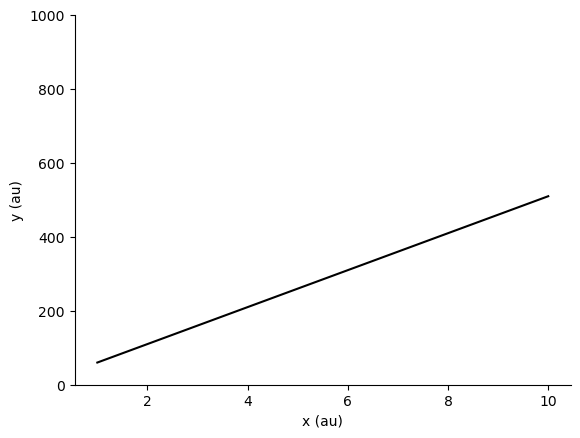

In [226]:
###Main block
#Compute modl results
data = optoData \
     = toyModl(m = 50)

#Visualization
plt.figure()
plt.plot(data['x'], 
         data['y'],
         color = 'black')
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)
plt.show()

### Optimize Toy Model To Target Data Using Random Parameter Search

In [279]:
###Fxn block
def sideBySide(*dfs):
    '''

    Jupyter render fxn, placing dfs side-by-side
    
    '''
    
    # This is the giant div element. We will display this at the end
    # Display:flex makes the div's children stack sideways
    html = '<div style="display:flex">'

    # Iterating through dataframes
    for df in dfs:
        # Putting each table in a div + setting a small margin
        html += '<div style="margin-right: 2em">'

        # The actual table HTML string
        html += df.to_html()

        # Closing the div
        html += '</div>'

    # Closing the root div
    html += '</div>'

    # Displaying the root div
    display(HTML(html))

###Main block
##Initialize iterator
i = 0

##Create conditional boundary
n = 10 - 1

#DAQ tenseor instantiations
modls = []
error = []

#Compute modl outputs subject to Monte-Carlo m selection
while i <= n:
    modls.append(toyModl(m = uniform(0, 101))['y'] \
         .rename(f'y{i}'))

    #Capture error signal
    error.append(mse(optoData['y'], modls[i]))

    #Increase iterator
    i += 1
    
#Transform to nd heterogenous df
data = pd.concat(modls, axis = 1)
data_ = pd.DataFrame({'modl': data.columns.values,
                      'err': error})

# #I.O
sideBySide(data, data_)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9
0,83.765294,19.389571,93.780122,49.457920,62.264398,45.350139,18.214832,110.556224,22.607297,32.638897
1,157.530589,28.779142,177.560243,88.915841,114.528797,80.700278,26.429664,211.112449,35.214595,55.277794
2,231.295883,38.168714,261.340365,128.373761,166.793195,116.050417,34.644496,311.668673,47.821892,77.916690
3,305.061177,47.558285,345.120487,167.831682,219.057594,151.400556,42.859329,412.224897,60.429190,100.555587
4,378.826472,56.947856,428.900609,207.289602,271.321992,186.750695,51.074161,512.781122,73.036487,123.194484
5,452.591766,66.337427,512.680730,246.747522,323.586391,222.100834,59.288993,613.337346,85.643784,145.833381
6,526.357060,75.726998,596.460852,286.205443,375.850789,257.450973,67.503825,713.893570,98.251082,168.472277
7,600.122355,85.116570,680.240974,325.663363,428.115187,292.801111,75.718657,814.449794,110.858379,191.111174
8,673.887649,94.506141,764.021096,365.121283,480.379586,328.151250,83.933489,915.006019,123.465677,213.750071
9,747.652943,103.895712,847.801217,404.579204,532.643984,363.501389,92.148321,1015.562243,136.072974,236.388968


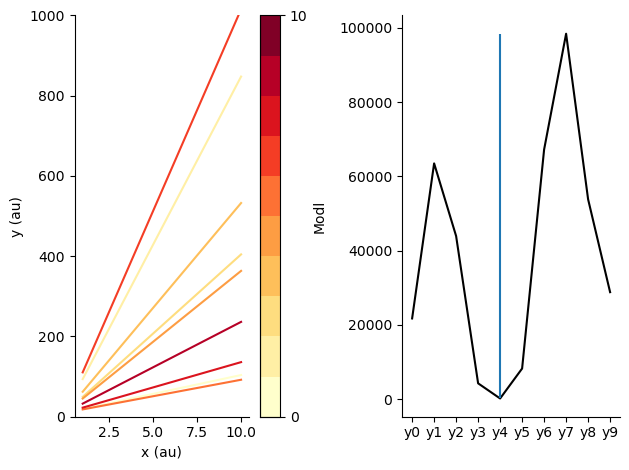

In [301]:
##Visualization
#Creation of graphics device
plt.figure()

#Creation of first panel (model data)
plt.subplot(121)

#Define colormap
cmap = cm.get_cmap('YlOrRd', len(data.iloc[:, 1:]))
cols = cmap(range(len(data.iloc[:, 1:])))

#Construct iteratively each panel
for i, val in enumerate(data.iloc[:, 1:]):
    plt.plot(np.arange(1, (10 + 1)),
             data[val],
             color = cols[i])

#Alter graphics device attributes
sbn.despine()
plt.xlabel('x (au)')
plt.ylabel('y (au)')
plt.ylim(0, 1000)

#Create ScalarMappable
sm = cm.ScalarMappable(cmap = cmap)

#Build legend through cbar constructor
cbar = plt.colorbar(sm, ticks = [0, 1])
cbar.set_label('Modl')
cbar.ax.set_yticklabels(['0', '10'])

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(data_['modl'], 
         data_['err'],
         color = 'black')
sbn.despine()

#Identify min in error landscape
plt.vlines(data_[(data_['err'] == min(data_['err']))]['modl'].values, 
           data_['err'].min(), 
           data_['err'].max())

#Alter subplot layout
plt.tight_layout()

#Render visualization to jupyter
plt.show()